## Origen de los datos: https://openweathermap.org/api/air-pollution (OpenWeather API)

Primero que nada, obtuve la información en formato de JSON gracias a la API de la pagina de OpenWeather. Le consulte a la api por las coordenadas especificas de Manhattan a partir del año 2020 hasta la actualidad. Descargue el archivo y ahora lo cargaré para empezar a procesar esa data

---

In [1]:
import pandas as pd
import json
import datetime
import requests
from geopy.geocoders import Nominatim
from datetime import datetime

### Para poder utilizar los archivos del Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargo los archivos JSON de cada Borough

In [ ]:
with open('/content/drive/airquality_Manhattan_2020-2023.json') as manhattan_data:
  manhattan_aq = json.load(manhattan_data)

FileNotFoundError: ignored

In [ ]:
def cleaning(json_data, borough):
  # Diccionario que va a contener solo la información valiosa
  clean_data = {
    'unix_date': [],
    'co': [],
    'pm2.5': [],
    'pm10': []
  }

  for dictt in json_data['list']:
    clean_data['unix_date'].append(dictt['dt'])
    clean_data['co'].append(dictt['components']['co'])
    clean_data['pm2.5'].append(dictt['components']['pm2_5'])
    clean_data['pm10'].append(dictt['components']['pm10'])

  df = pd.DataFrame(clean_data)
  df['datetime'] = df['unix_date'].apply(lambda x: datetime.datetime.fromtimestamp(x))
  df['date'] = df['unix_date'].apply(lambda x: datetime.datetime.fromtimestamp(x).date())
  df['time'] = df['unix_date'].apply(lambda x: datetime.datetime.fromtimestamp(x).time())
  df['borough'] = borough
  df['city'] = 'New York'
  df['country'] = 'US'
  df['date'] = pd.to_datetime(df['date'])
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['quarter'] = df['date'].dt.quarter

  df.drop(columns=['unix_date'], inplace = True)

  # Reordeno el dataframe para que tengan un mejor aspecto
  df = df[['country','city','borough','datetime','date','time','year','month','quarter','day','co', 'pm2.5', 'pm10']]

  return df

In [ ]:
manhattan_df = cleaning(manhattan_aq, 'Manhattan')
manhattan_df

,country,city,borough,datetime,date,time,year,month,quarter,day,co,pm2.5,pm10
0,US,New York,Manhattan,2020-11-25 01:00:00,2020-11-25,01:00:00,2020,11,4,25,1815.80,63.81,90.35
1,US,New York,Manhattan,2020-11-25 02:00:00,2020-11-25,02:00:00,2020,11,4,25,2056.12,77.15,110.21
2,US,New York,Manhattan,2020-11-25 03:00:00,2020-11-25,03:00:00,2020,11,4,25,2189.64,86.94,126.06
3,US,New York,Manhattan,2020-11-25 04:00:00,2020-11-25,04:00:00,2020,11,4,25,2349.85,96.19,141.36
4,US,New York,Manhattan,2020-11-25 05:00:00,2020-11-25,05:00:00,2020,11,4,25,2109.53,83.11,129.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23583,US,New York,Manhattan,2023-08-15 16:00:00,2023-08-15,16:00:00,2023,8,3,15,337.12,6.71,7.81
23584,US,New York,Manhattan,2023-08-15 17:00:00,2023-08-15,17:00:00,2023,8,3,15,333.79,7.29,8.27
23585,US,New York,Manhattan,2023-08-15 18:00:00,2023-08-15,18:00:00,2023,8,3,15,337.12,9.41,10.40
23586,US,New York,Manhattan,2023-08-15 19:00:00,2023-08-15,19:00:00,2023,8,3,15,350.48,12.16,13.24


## Descarga de los dataframes a archivos csv

In [ ]:
def download(df, file_name):
  df.to_csv(f'/content/drive/MyDrive/Proyecto Final Henry/Uriel/Air Quality per Boroughs/Archivos CSV/{file_name}',sep=',')

In [ ]:
# download(manhattan_df, 'Manhattan_AirQuality_2020_2023')

## Breve analisis de los datos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
data = manhattan_df.groupby(by=['year','month']).mean().reset_index()[['year','month','co']]
data['year'] = pd.to_datetime(data['year'], format='%Y')
data['month'] = pd.to_datetime(data['month'], format='%m')

<ipython-input-45-2d11f4121686>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = manhattan_df.groupby(by=['year','month']).mean().reset_index()[['year','month','co']]


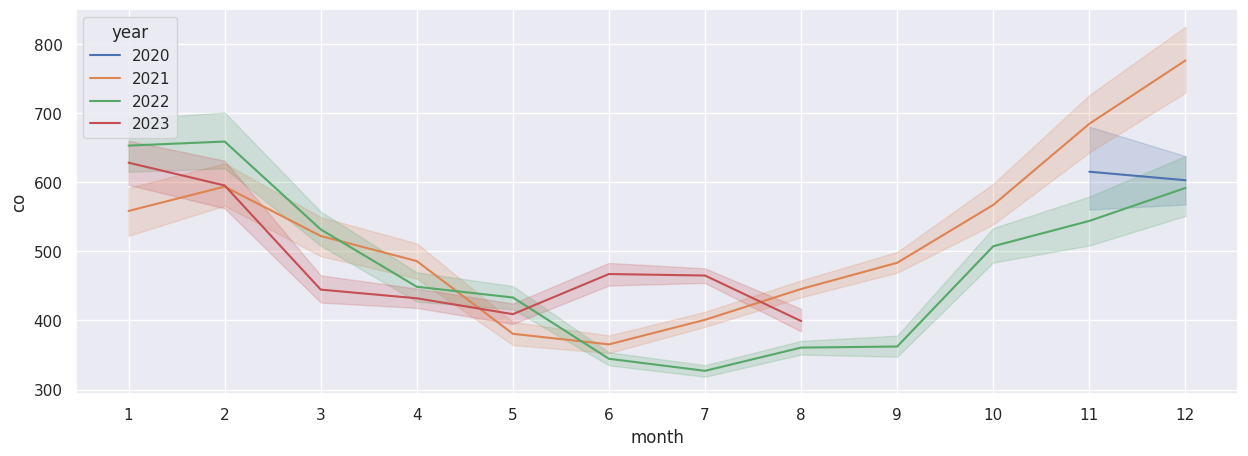

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data = manhattan_df, x='month', y='co', hue='year', palette='deep')
plt.xticks(ticks=range(1,13), labels=range(1,13))
plt.show()

**Estaciones climaticas en Manhattan:**
- Invierno: de diciembre a marzo
- Primavera: de marzo a junio
- Verano: de junio a septiembre
- Otoño: de septiembre a diciembre

<mark>**En los meses en los cuales la ciudad de Manhattan se encuentra con climas frios (en invierno), las concentraciones del monoxido de carbono en el aire suelen ser mucho mas elevadas a diferencia en los meses en los cuales en Manhattan hace calor (en la estación de verano/primavera)**</mark>

---
# Obtención de datos mediante la API

In [3]:
zones_names = ['Alphabet City', 'Battery Park', 'Battery Park City', 'Bloomingdale', 'Central Harlem', 'Central Harlem North', 'Central Park', 'Chinatown', 'Clinton East', 'Clinton West', 'East Chelsea', 'East Harlem South', 'East Village', 'Financial District South', 'Flatiron', 'Garment District', "Governor's Island/Ellis Island/Liberty Island", 'Gramercy', 'Greenwich Village South', 'Hamilton Heights', 'Highbridge Park', 'Hudson Sq', 'Inwood', 'Inwood Hill Park', 'Kips Bay', 'Lenox Hill East', 'Lincoln Square East', 'Lincoln Square West', 'Lower East Side', 'Manhattan Valley', 'Manhattanville', 'Marble Hill', 'Midtown Center', 'Midtown East', 'Midtown North', 'Midtown South', 'Morningside Heights', 'Murray Hill', 'Randalls Island', 'Roosevelt Island', 'Seaport', 'SoHo', 'Sutton Place/Turtle Bay North', 'Times Sq/Theatre District', 'Two Bridges/Seward Park', 'Union Sq', 'Upper East Side South', 'Upper West Side South', 'Washington Heights South', 'West Chelsea/Hudson Yards', 'West Village', 'World Trade Center', 'Yorkville East', 'East Harlem', 'Financial District', 'Governors Island', 'Ellis Island', 'Liberty Island', 'Greenwich Village', 'Lenox Hill West', 'Little Italy', 'NoLiTa', 'Meatpacking', 'West Village West', 'Midtown Center', 'Penn Station', 'Madison Sq West', 'Stuy Town', 'Peter Cooper Village', 'Sutton Place', 'Turtle Bay', 'TriBeCa', 'Civic Center', 'Two Bridges', 'Seward Park', 'UN', 'Upper East Side', 'Upper West Side', 'Washington Heights', 'Yorkville West']
locations_ids = [4, 12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 75, 79, 88, 90, 100, 104, 107, 114, 116, 120, 125, 127, 128, 137, 140, 142, 143, 148, 151, 152, 153, 161, 162, 163, 164, 166, 170, 194, 202, 209, 211, 229, 230, 232, 234, 237, 239, 244, 246, 249, 261, 262, 74, 87, 103, 103, 103, 113, 141, 144, 144, 158, 158, 161, 186, 186, 224, 224, 229, 229, 231, 231, 232, 232, 233, 236, 238, 243, 263]

In [4]:
api_key = 'e49a90e730e178434b65ddc9689cbf9d'
dfs = []

In [5]:
# Inicializar el geolocalizador de Nominatim
geolocator = Nominatim(user_agent="my_geocoder", timeout=10)
fails_zones = {
    'Zone':[],
    'IdZone':[]
}

start_date = '2020-11-27'
start_date_datetime = datetime.strptime(start_date, "%Y-%m-%d")
start_date_unix = start_date_datetime.timestamp()

end_date = f'{datetime.now().date()}'
end_date_datetime = datetime.strptime(end_date, "%Y-%m-%d")
end_date_unix = end_date_datetime.timestamp()

# Obtener las coordenadas de cada ciudad/barrio
for index, zone in enumerate(zones_names[:5]):
    location = geolocator.geocode(zone + ", Manhattan, New York, USA")
    # URL de la API con tus valores de latitud, longitud y API key

    if location is None:
      fails_zones['Zone'].append(zone)
      fails_zones['IdZone'].append(locations_ids[index])
      continue
    else:
      lat = location.latitude
      lon = location.longitude
      start = int(start_date_unix)
      end = int(end_date_unix)

      url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={api_key}"

      # Realizar la solicitud a la API
      response = requests.get(url)

      data = response.json()
      clean_data = {
          'unix_date': [],
          'co': [],
          'pm2.5': [],
          'pm10': []
        }

      for dictt in data['list']:
        clean_data['unix_date'].append(dictt['dt'])
        clean_data['co'].append(dictt['components']['co'])
        clean_data['pm2.5'].append(dictt['components']['pm2_5'])
        clean_data['pm10'].append(dictt['components']['pm10'])

      df = pd.DataFrame(clean_data)
      df['latitude'] = lat
      df['longitude'] = lon
      df['datetime'] = df['unix_date'].apply(lambda x: datetime.fromtimestamp(x))
      df['date'] = df['unix_date'].apply(lambda x: datetime.fromtimestamp(x).date())
      df['time'] = df['unix_date'].apply(lambda x: datetime.fromtimestamp(x).time())
      df['borough'] = 'Manhattan'
      df['zone'] = zone
      df['idzone'] = locations_ids[index]
      df['city'] = 'New York'
      df['date'] = pd.to_datetime(df['date'])
      df['year'] = df['date'].dt.year
      df['month'] = df['date'].dt.month
      df['day'] = df['date'].dt.day
      df['quarter'] = df['date'].dt.quarter

      df.drop(columns=['unix_date'], inplace = True)
      dfs.append(df)


df = pd.concat(dfs, ignore_index=True)
df = df[['datetime',
       'date',
       'year',
       'quarter',
       'month',
       'day',
       'time',
       'city',
       'borough',
       'zone',
       'idzone',
       'latitude',
       'longitude',
       'co',
       'pm2.5',
       'pm10'
       ]]

df = df.sort_values(by='datetime', ascending=False).reset_index(drop=True)

In [16]:
df

,datetime,date,year,quarter,month,day,time,city,borough,zone,idzone,latitude,longitude,co,pm2.5,pm10
0,2023-09-04,2023-09-04,2023,3,9,4,00:00:00,New York,Manhattan,Central Harlem,41,40.798275,-73.952530,687.60,20.90,32.09
1,2023-09-04,2023-09-04,2023,3,9,4,00:00:00,New York,Manhattan,Battery Park,12,40.702786,-74.015773,727.65,25.57,34.83
2,2023-09-04,2023-09-04,2023,3,9,4,00:00:00,New York,Manhattan,Battery Park City,13,40.711017,-74.016937,727.65,25.57,34.83
3,2023-09-04,2023-09-04,2023,3,9,4,00:00:00,New York,Manhattan,Alphabet City,4,40.725102,-73.979583,687.60,20.90,32.09
4,2023-09-04,2023-09-04,2023,3,9,4,00:00:00,New York,Manhattan,Bloomingdale,24,40.799776,-73.967772,687.60,20.90,32.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120000,2020-11-27,2020-11-27,2020,4,11,27,00:00:00,New York,Manhattan,Battery Park,12,40.702786,-74.015773,680.92,15.29,23.04
120001,2020-11-27,2020-11-27,2020,4,11,27,00:00:00,New York,Manhattan,Central Harlem,41,40.798275,-73.952530,680.92,15.29,23.04
120002,2020-11-27,2020-11-27,2020,4,11,27,00:00:00,New York,Manhattan,Battery Park City,13,40.711017,-74.016937,680.92,15.29,23.04
120003,2020-11-27,2020-11-27,2020,4,11,27,00:00:00,New York,Manhattan,Bloomingdale,24,40.799776,-73.967772,680.92,15.29,23.04


In [11]:
# Supongamos que tienes un dataframe llamado 'df' con todas las columnas originales
# y deseas seleccionar los valores únicos de 'idzone' y crear un nuevo dataframe

# Seleccionar valores únicos de 'idzone'
valores_unicos_idzone = df['idzone'].unique()

In [12]:
# Crear un nuevo dataframe con las columnas especificadas
nuevo_df = df[['city', 'borough', 'zone', 'idzone', 'latitude', 'longitude']]

In [9]:
# Mostrar los valores únicos de 'idzone' y el nuevo dataframe
print("Valores únicos de 'idzone':")
print(valores_unicos_idzone)

print("\nNuevo DataFrame:")
print(nuevo_df)

Valores únicos de 'idzone':
[41 12 13  4 24]

Nuevo DataFrame:
            city    borough               zone  idzone   latitude  longitude
0       New York  Manhattan     Central Harlem      41  40.798275 -73.952530
1       New York  Manhattan       Battery Park      12  40.702786 -74.015773
2       New York  Manhattan  Battery Park City      13  40.711017 -74.016937
3       New York  Manhattan      Alphabet City       4  40.725102 -73.979583
4       New York  Manhattan       Bloomingdale      24  40.799776 -73.967772
...          ...        ...                ...     ...        ...        ...
120000  New York  Manhattan       Battery Park      12  40.702786 -74.015773
120001  New York  Manhattan     Central Harlem      41  40.798275 -73.952530
120002  New York  Manhattan  Battery Park City      13  40.711017 -74.016937
120003  New York  Manhattan       Bloomingdale      24  40.799776 -73.967772
120004  New York  Manhattan      Alphabet City       4  40.725102 -73.979583

[120005 rows

In [15]:
df["idzone"].describe()

count    120005.000000
mean         18.800000
std          12.796928
min           4.000000
25%          12.000000
50%          13.000000
75%          24.000000
max          41.000000
Name: idzone, dtype: float64